
# Neural XC training: MLP models 

Note: To showcase the training process we only use 2 epochs.

The following steps are performed:

1. Load configuration
2. Load dataset
3. Define model
4. Train model


In [1]:
import os
import sys
from pathlib import Path

import glob
import json
import pickle
import time

import jax
from jax import random
from jax import tree_util
from jax import config
import jax.numpy as jnp
from jax_dft import datasets
from jax_dft import jit_scf
from jax_dft import losses
from jax_dft import neural_xc
from jax_dft import np_utils
from jax_dft import scf
from jax_dft import utils
from jax_dft import xc
import matplotlib.pyplot as plt
import numpy as np
import scipy

import qedft
from qedft.config.config import Config
from qedft.data_io.dataset_loader import load_molecular_datasets_from_config
from qedft.train.od.train import create_kohn_sham_fn, create_loss_fn, create_training_step

# Set the default dtype as float64
config.update('jax_enable_x64', True)
project_path = os.path.dirname(os.path.dirname(qedft.__file__))
print(f"Project path: {project_path}")

# Initialize a configuration object to manage our settings
# Define the project path, assuming 'settings.yaml' is located in the root directory
project_path = Path(os.path.dirname(os.path.dirname(qedft.__file__)))

# Load configuration settings from a YAML file
config = Config(config_path=project_path / 'qedft' / 'config' / 'train_config.yaml')
config_dict = config.config
config_dict

Project path: /Users/igorsokolov/PycharmProjects/qex


{'name': 'test',
 'experiment_name': 'test',
 'network_type': 'ksr',
 'molecule_name': 'h2',
 'molecule_names': ['h2'],
 'dataset1': [128, 384],
 'rng': 0,
 'save_plot_loss': False,
 'save_every_n': 20,
 'activation': 'tanh',
 'n_neurons': 513,
 'n_layers': 2,
 'n_qubits': 9,
 'n_reupload_layers': 1,
 'use_rzz_parametrized_entanglers': False,
 'chebychev_reuploading': False,
 'add_reversed_rzz': False,
 'entangling_block_type': 'alternate_linear',
 'single_qubit_rotations': ['rz', 'rx', 'rz'],
 'use_same_parameters': False,
 'add_negative_transform': False,
 'wrap_with_self_interaction_layer': False,
 'wrap_with_global_functional': False,
 'use_correlators_in_output': False,
 'output_operators': ['Z'],
 'use_bias_in_output': False,
 'max_train_steps': 10000,
 'factr': 1.0,
 'pgtol': 1e-14,
 'm': 20,
 'maxfun': 20,
 'maxiter': 2,
 'num_iterations': 15,
 'ks_iter_to_ignore': 10,
 'discount_factor': 0.9,
 'alpha': 0.5,
 'alpha_decay': 0.9,
 'num_mixing_iterations': 1,
 'density_mse_conver

In [2]:
# Training on H2 molecule
# config_dict['dataset1'] = [80, 128, 192, 240, 384, 448, 544, 592]

In [3]:
# Load the datasets
base_path = project_path / "data" / "od"
base_path = Path(base_path)
list_datasets = load_molecular_datasets_from_config(
    config_dict,
    base_path,
    check_grid_centering=True
)

dataset = list_datasets[0][0]  # first dataset
train_set = list_datasets[0][1] # train set

# Same grids for all datasets
grids = dataset.grids
initial_density = scf.get_initial_density(train_set, method='noninteracting')
initial_density  # initial density for training set
# save initial density
# with open('initial_density.pkl', 'wb') as f:
#     pickle.dump(initial_density, f)

2025-06-11 13:57:30.342 | INFO     | qedft.data_io.dataset_loader:load_molecular_datasets:63 - Loading dataset for h2
2025-06-11 13:57:30.343 | INFO     | qedft.data_io.dataset_loader:load_molecular_datasets:83 - Loading dataset from /Users/igorsokolov/PycharmProjects/qex/data/od/h2
2025-06-11 13:57:30.346 | INFO     | qedft.data_io.dataset_loader:load_molecular_datasets:95 - Training distances: [128, 384]
2025-06-11 13:57:30.347 | INFO     | qedft.data_io.dataset_loader:load_molecular_datasets:101 - Number of electrons: 2
2025-06-11 13:57:30.347 | INFO     | qedft.data_io.dataset_loader:load_molecular_datasets:102 - Grid shape: (513,)


Array([[1.36119039e-28, 5.94445108e-28, 1.41265059e-27, ...,
        1.41169566e-27, 5.94277752e-28, 1.35987023e-28],
       [1.93532725e-23, 8.40951795e-23, 1.98255792e-22, ...,
        1.98255588e-22, 8.40953719e-23, 1.93532880e-23]], dtype=float64)

***
## Training with Local MLP model

In [4]:
# Local MLP model
config_dict.update({'use_amplitude_encoding': False})  # Global XC model disabled
config_dict.update({'network_type': 'mlp'})  # Local XC model

In [5]:
from qedft.models.classical.classical_models import build_local_mlp
from qedft.models.wrappers import wrap_network_from_config

num_grids = len(grids)
rng_key = jax.random.PRNGKey(1)
inputs = jax.random.uniform(rng_key, shape=(num_grids,))

# Example usage with direct initialization
network = build_local_mlp(
    n_neurons=num_grids,
    n_layers=2,
    activation="tanh",
    n_outputs=1,
    rng_key = rng_key,
    density_normalization_factor=2.0,
    grids=grids
)
wrapped_network = wrap_network_from_config(network, grids, config_dict)
# Test direct initialization networks
init_fn, neural_xc_energy_density_fn = wrapped_network
init_params = init_fn(rng_key, input_shape=(1,))

# JIT the neural_xc_energy_density_fn
neural_xc_energy_density_fn = jax.jit(neural_xc_energy_density_fn)
output = neural_xc_energy_density_fn(inputs, init_params)
print("Checking output.shape is (num_density_points,)", output.shape)

# Flatten parameters
spec, flatten_init_params = np_utils.flatten(init_params)
inputs = jax.random.uniform(
    rng_key,
    minval=-4 * jnp.pi,
    maxval=4 * jnp.pi,
    shape=(num_grids,),
)
params = init_fn(rng_key)
# Test the neural_xc_energy_density_fn
neural_xc_energy_density_fn(inputs, params)

Checking output.shape is (num_density_points,) (513,)


Array([ 0.18648678, -0.26920184, -0.13208294, -0.15940552, -0.10039828,
       -0.00598103,  0.23323322,  0.32559069,  0.31616278, -0.29417573,
       -0.33662824, -0.45721903,  0.28867897, -0.44558261, -0.44607986,
       -0.07696131,  0.17221896,  0.24343917,  0.05821774, -0.32380406,
       -0.37466052,  0.19519575, -0.45639601,  0.22156175, -0.39040425,
        0.33153778, -0.3889806 , -0.10213254, -0.19374626, -0.21659525,
       -0.31350296,  0.09992205,  0.35215629, -0.14518176, -0.28693773,
       -0.38371883,  0.25064643,  0.04176956, -0.33275987, -0.38195223,
       -0.4680399 , -0.43755984,  0.38576895, -0.3113181 , -0.38422481,
       -0.31103728,  0.27589772, -0.35314842,  0.22524972, -0.42829263,
        0.21601003, -0.20524848,  0.28800871, -0.3695858 ,  0.04798845,
       -0.45281017,  0.16451808, -0.4131061 , -0.46182773, -0.38802917,
        0.25259601,  0.24364324,  0.02938442, -0.471496  ,  0.00182066,
        0.158655  ,  0.11709101,  0.22749529, -0.12923031, -0.17

In [6]:
# Create Kohn-Sham function and its batched version
kohn_sham_fn, batch_kohn_sham = create_kohn_sham_fn(
    config_dict, dataset, grids, neural_xc_energy_density_fn, spec)

# Create and initialize loss function
loss_fn = create_loss_fn(batch_kohn_sham, grids, dataset, config_dict)

# Create value and gradient function
value_and_grad_fn = jax.jit(jax.value_and_grad(loss_fn))

# Create training step function
training_step = create_training_step(
    value_and_grad_fn, train_set, initial_density,
    save_every_n=1, initial_checkpoint_index=0, checkpoint_dir=project_path / 'tests' / 'local_mlp' / 'ckpts', spec=spec
)

In [7]:
# Optimize using L-BFGS-B
x, f, info = scipy.optimize.fmin_l_bfgs_b(
    training_step,
    x0=np.array(flatten_init_params),
    maxfun=2,  # 200
    factr=1,  # 1e12 factr * machine epsilon (1e-15) = tolerance
    m=20,  # 10
    pgtol=1e-14,
    maxiter=2  # 200
)
x, f,info

2025-06-11 13:57:31.492 | INFO     | qedft.train.od.train:_kohn_sham:116 - Jitting kohn_sham_func
2025-06-11 13:57:34.646 | INFO     | qedft.train.od.train:np_value_and_grad_fn:454 - step 0, loss 0.707515708341942 in 1.4233667850494385 sec
2025-06-11 13:57:34.647 | INFO     | qedft.train.od.train:np_value_and_grad_fn:458 - Save checkpoint /Users/igorsokolov/PycharmProjects/qex/tests/local_mlp/ckpts/ckpt-00000
2025-06-11 13:57:36.442 | INFO     | qedft.train.od.train:np_value_and_grad_fn:454 - step 1, loss 32.55054416872726 in 0.0001277923583984375 sec
2025-06-11 13:57:36.442 | INFO     | qedft.train.od.train:np_value_and_grad_fn:458 - Save checkpoint /Users/igorsokolov/PycharmProjects/qex/tests/local_mlp/ckpts/ckpt-00001
2025-06-11 13:57:38.051 | INFO     | qedft.train.od.train:np_value_and_grad_fn:454 - step 2, loss 0.01291082594872716 in 0.00015592575073242188 sec
2025-06-11 13:57:38.051 | INFO     | qedft.train.od.train:np_value_and_grad_fn:458 - Save checkpoint /Users/igorsokolov/P

(array([-0.0369136 ,  0.014845  , -0.08570003, ...,  0.01665304,
         0.10446101, -0.08042258], shape=(265222,)),
 0.01291082594872716,
 {'grad': array([ 0.00126947, -0.00396613,  0.00186197, ...,  0.00206122,
          0.00217285,  0.00756448], shape=(265222,)),
  'task': 'STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT',
  'funcalls': 3,
  'nit': 1,
  'warnflag': 1})

## Evaluation

In [8]:
from qedft.train.od.eval import eval_trained_model

# Plotting the states of the Kohn-Sham calculation for a given distance.
plot_distances = [40, 88, 128, 184, 232,384, 400, 504, 584] #@param
plot_set = dataset.get_molecules(plot_distances)
plot_initial_density = scf.get_initial_density(
    plot_set, method='noninteracting')
nuclear_energy = utils.get_nuclear_interaction_energy_batch(
    plot_set.locations,
    plot_set.nuclear_charges,
    interaction_fn=utils.exponential_coulomb)

path_to_ckpt = str(project_path) + '/tests/local_mlp/ckpts/ckpt-00002'

# Evaluating the trained model for a given distance.
states_local_mlp = eval_trained_model(
    ckpt_path=path_to_ckpt,
    plot_distances=plot_distances,
    plot_set=plot_set,
    plot_initial_density=plot_initial_density,
    num_electrons=dataset.num_electrons,
    num_iterations=config_dict['num_iterations'],
    grids=grids,
    neural_xc_energy_density_fn=neural_xc_energy_density_fn,
    use_amplitude_encoding=False,
    use_lda=False,
    alpha=config_dict['alpha'],
    alpha_decay=config_dict['alpha_decay'],
    num_mixing_iterations=2,  # config_dict['num_mixing_iterations'],
    density_mse_converge_tolerance=config_dict['density_mse_converge_tolerance'],
    enforce_reflection_symmetry=config_dict['enforce_reflection_symmetry'],
    output_path=project_path / 'tests' / 'local_mlp' / 'states.pkl'
)

2025-06-11 13:57:38.522 | INFO     | qedft.train.od.eval:load_model_params:102 - Loading checkpoint from /Users/igorsokolov/PycharmProjects/qex/tests/local_mlp/ckpts/ckpt-00002
2025-06-11 13:57:38.523 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 40
2025-06-11 13:57:39.906 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 88
2025-06-11 13:57:40.498 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 128
2025-06-11 13:57:41.094 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 184
2025-06-11 13:57:41.725 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 232
2025-06-11 13:57:42.319 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 384
2025-06-11 13:57:42.921 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 400
2025-06-11 13:57:43.600 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 504
2025-06-11 13:57:44.211 | INFO     | qedf

In [9]:
import copy
# Load states
try:
    with open(project_path / 'tests' / 'local_mlp' / 'states.pkl', 'rb') as f:
        states_local_mlp = pickle.load(f)
except:
    print("No checkpoint found. Evaluating from scratch.")
    states_local_mlp = copy.deepcopy(states_local_mlp)

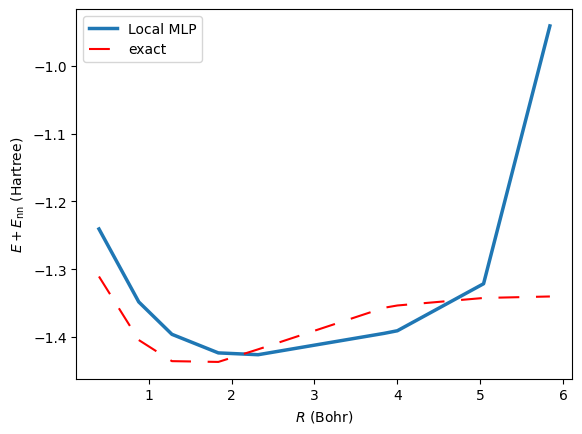

In [10]:
plt.plot(
    np.array(plot_distances) / 100,
    nuclear_energy + states_local_mlp.total_energy[:, -1], lw=2.5, label='Local MLP')
plt.plot(
    np.array(plot_distances) / 100,
    nuclear_energy + plot_set.total_energy,
    c='r', dashes=(10, 8), label='exact')
plt.xlabel(r'$R\,\,\mathrm{(Bohr)}$')
plt.ylabel(r'$E+E_\mathrm{nn}\,\,\mathsf{(Hartree)}$')
plt.legend(loc=0)
plt.show()

***
## Training with Global MLP model

In [11]:
config_dict.update({'use_amplitude_encoding': True})
config_dict.update({'network_type': 'mlp_ksr'})

In [12]:
from qedft.models.classical.classical_models import build_global_mlp
from qedft.models.wrappers import wrap_network_from_config

num_grids = len(grids)
rng_key = jax.random.PRNGKey(0)
inputs = jax.random.uniform(rng_key, shape=(num_grids,))

# Example usage with direct initialization
network = build_global_mlp(
    n_neurons=513,
    n_layers=2,
    activation="tanh",
    n_outputs=1,
    rng_key = rng_key,
    density_normalization_factor=2.0,
    grids=grids
)
wrapped_network = wrap_network_from_config(network, grids, config_dict)

# Test direct initialization networks
init_fn, neural_xc_energy_density_fn = wrapped_network
init_params = init_fn(rng_key, input_shape=(1,))

# JIT the neural_xc_energy_density_fn
neural_xc_energy_density_fn = jax.jit(neural_xc_energy_density_fn)

output = neural_xc_energy_density_fn(inputs, init_params)
print("output.shape", output.shape)

# Flatten parameters
spec, flatten_init_params = np_utils.flatten(init_params)
inputs = jax.random.uniform(
    rng_key,
    minval=-4 * jnp.pi,
    maxval=4 * jnp.pi,
    shape=(num_grids,),
)
params = init_fn(rng_key)

# Test the neural_xc_energy_density_fn
neural_xc_energy_density_fn(inputs, params)

2025-06-11 13:57:45.265 | INFO     | qedft.models.wrappers:wrap_network:205 - Global model, ensuring output is scalar (wrap_self_interaction causes global models to output (num_grids,) instead of (1,))


output.shape ()


Array(-1.36720443, dtype=float64)

In [13]:
# Create Kohn-Sham function and its batched version
kohn_sham_fn, batch_kohn_sham = create_kohn_sham_fn(
    config_dict, dataset, grids, neural_xc_energy_density_fn, spec)

# Create and initialize loss function
loss_fn = create_loss_fn(batch_kohn_sham, grids, dataset, config_dict)

# Create value and gradient function
value_and_grad_fn = jax.jit(jax.value_and_grad(loss_fn))

# Create training step function
training_step = create_training_step(
    value_and_grad_fn, train_set, initial_density,
    save_every_n=1, initial_checkpoint_index=0, checkpoint_dir=project_path / 'tests' / 'global_mlp' / 'ckpts', spec=spec
)

In [14]:
from qedft.train.od.eval import load_model_params

# Load checkpoint
try:
    path_to_ckpt = str(project_path) + '/tests/global_mlp/ckpts/ckpt-00002'
    params = load_model_params(path_to_ckpt)
    _, flatten_init_params = np_utils.flatten(params)
except:
    print("No checkpoint found. Training from scratch.")
    _, flatten_init_params = np_utils.flatten(params)


2025-06-11 13:57:45.323 | INFO     | qedft.train.od.eval:load_model_params:102 - Loading checkpoint from /Users/igorsokolov/PycharmProjects/qex/tests/global_mlp/ckpts/ckpt-00002


No checkpoint found. Training from scratch.


In [15]:
# Optimize using L-BFGS-B
x, f, info = scipy.optimize.fmin_l_bfgs_b(
    training_step,
    x0=np.array(flatten_init_params),
    maxfun=2,  # 200
    factr=1,  # 1e12 factr * machine epsilon (1e-15) = tolerance
    m=20,  # 10
    pgtol=1e-14,
    maxiter=2  # 200
)
x, f,info

2025-06-11 13:57:45.346 | INFO     | qedft.train.od.train:_kohn_sham:116 - Jitting kohn_sham_func
2025-06-11 13:57:47.494 | INFO     | qedft.train.od.train:np_value_and_grad_fn:454 - step 0, loss 0.8545335634927178 in 1.086308240890503 sec
2025-06-11 13:57:47.495 | INFO     | qedft.train.od.train:np_value_and_grad_fn:458 - Save checkpoint /Users/igorsokolov/PycharmProjects/qex/tests/global_mlp/ckpts/ckpt-00000
2025-06-11 13:57:48.618 | INFO     | qedft.train.od.train:np_value_and_grad_fn:454 - step 1, loss 0.23350827770135318 in 0.0001201629638671875 sec
2025-06-11 13:57:48.619 | INFO     | qedft.train.od.train:np_value_and_grad_fn:458 - Save checkpoint /Users/igorsokolov/PycharmProjects/qex/tests/global_mlp/ckpts/ckpt-00001
2025-06-11 13:57:49.720 | INFO     | qedft.train.od.train:np_value_and_grad_fn:454 - step 2, loss 1.957876573887147 in 0.00011801719665527344 sec
2025-06-11 13:57:49.721 | INFO     | qedft.train.od.train:np_value_and_grad_fn:458 - Save checkpoint /Users/igorsokolov

(array([ 0.01091407, -0.02111906, -0.01402344, ..., -0.09565958,
         0.08226817, -0.37299881], shape=(527878,)),
 0.022768604429062554,
 {'grad': array([ 5.01516266e-13,  1.33174429e-12, -3.07822196e-12, ...,
          5.52123333e-03, -6.21179084e-03,  2.58453971e-02], shape=(527878,)),
  'task': 'STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT',
  'funcalls': 4,
  'nit': 2,
  'warnflag': 1})

In [16]:
from qedft.train.od.eval import eval_trained_model

# Plotting the states of the Kohn-Sham calculation for a given distance.
plot_distances = [40, 88, 128, 184, 232, 384, 400, 504, 600] #@param
plot_set = dataset.get_molecules(plot_distances)
plot_initial_density = scf.get_initial_density(
    plot_set, method='noninteracting')
nuclear_energy = utils.get_nuclear_interaction_energy_batch(
    plot_set.locations,
    plot_set.nuclear_charges,
    interaction_fn=utils.exponential_coulomb)

path_to_ckpt = str(project_path) + '/tests/global_mlp/ckpts/ckpt-00002'

In [17]:
# Evaluating the trained model for a given distance.
states_global_mlp = eval_trained_model(
    ckpt_path=path_to_ckpt,
    plot_distances=plot_distances,
    plot_set=plot_set,
    plot_initial_density=plot_initial_density,
    num_electrons=dataset.num_electrons,
    num_iterations=config_dict['num_iterations'],
    grids=grids,
    neural_xc_energy_density_fn=neural_xc_energy_density_fn,
    use_amplitude_encoding=True,
    use_lda=False,
    alpha=config_dict['alpha'],
    alpha_decay=config_dict['alpha_decay'],
    num_mixing_iterations=1,
    density_mse_converge_tolerance=config_dict['density_mse_converge_tolerance'],
    enforce_reflection_symmetry=config_dict['enforce_reflection_symmetry'],
    output_path=project_path / 'tests' / 'global_mlp' / 'states.pkl'
)

2025-06-11 13:57:51.123 | INFO     | qedft.train.od.eval:load_model_params:102 - Loading checkpoint from /Users/igorsokolov/PycharmProjects/qex/tests/global_mlp/ckpts/ckpt-00002
2025-06-11 13:57:51.125 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 40
2025-06-11 13:57:51.776 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 88
2025-06-11 13:57:52.314 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 128
2025-06-11 13:57:52.779 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 184
2025-06-11 13:57:53.218 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 232
2025-06-11 13:57:53.733 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 384
2025-06-11 13:57:54.167 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 400
2025-06-11 13:57:54.602 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 504
2025-06-11 13:57:55.037 | INFO     | qed

In [18]:
# Load states
with open(project_path / 'tests' / 'global_mlp' / 'states.pkl', 'rb') as f:
    states_global_mlp = pickle.load(f)

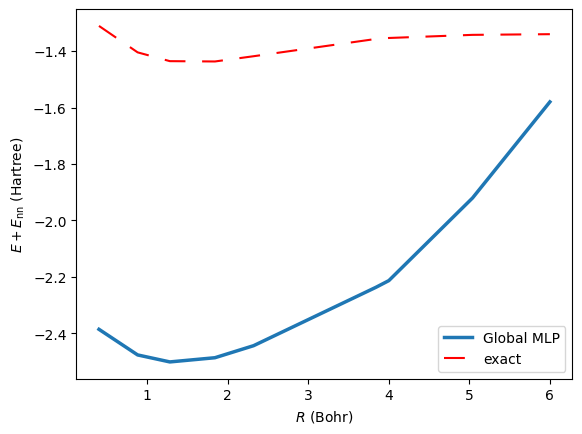

In [19]:
plt.plot(
    np.array(plot_distances) / 100,
    nuclear_energy + states_global_mlp.total_energy[:, -1], lw=2.5, label='Global MLP')
plt.plot(
    np.array(plot_distances) / 100,
    nuclear_energy + plot_set.total_energy,
    c='r', dashes=(10, 8), label='exact')
plt.xlabel(r'$R\,\,\mathrm{(Bohr)}$')
plt.ylabel(r'$E+E_\mathrm{nn}\,\,\mathsf{(Hartree)}$')
plt.legend(loc=0)
plt.show()

[(0.986509, 0.822401, 0.143557), (0.991985, 0.681179, 0.195295), (0.963203, 0.553865, 0.271909), (0.907365, 0.434524, 0.35297), (0.836801, 0.329105, 0.430905), (0.752312, 0.227133, 0.513149), (0.650746, 0.125309, 0.595617), (0.523633, 0.024532, 0.652901), (0.387183, 0.001434, 0.654177), (0.241396, 0.014979, 0.610259)]


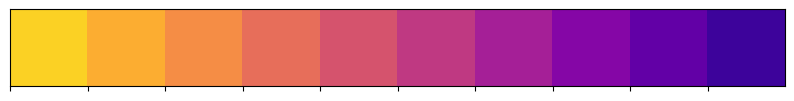

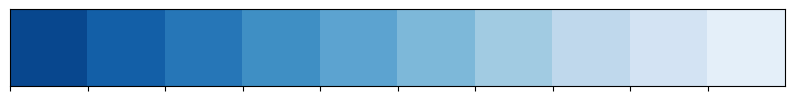

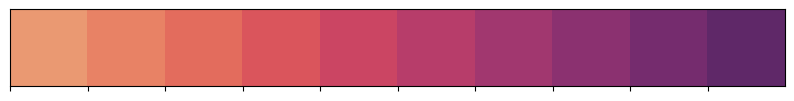

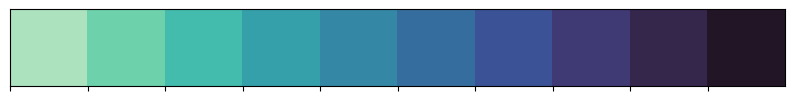

In [20]:
from qedft.utils.plot import PlotStyle
import seaborn as sns

# In plotter we can set a general palette
style = PlotStyle(palette_name="plasma_r", palette_size=10)
# Palletes of seaborn
print(style.palette)

# Palletes used in the paper
sns.palplot(sns.color_palette("plasma_r", 10))
sns.palplot(sns.color_palette("Blues_r", 10))
sns.palplot(sns.color_palette("flare", 10))
sns.palplot(sns.color_palette("mako_r", 10))

In [21]:
# Change the plot_results function to adjust
def plot_results(
    plot_distances,
    nuclear_energy,
    states,
    plot_set,
    title=None,
    save_path=None,
    show_legend=True,
    color_idx=4
):
    """
    Create a comprehensive plot for KSR model results.

    Parameters:
    -----------
    plot_distances : array-like
        The interatomic distances for plotting
    nuclear_energy : array-like
        Nuclear interaction energies
    states : KohnShamState
        KohnShamState object containing model results
    plot_set : object
        Dataset object containing exact/reference values
    title : str, optional
        Plot title
    save_path : str, optional
        Path to save the figure
    show_legend : bool, optional
        Whether to show the legend
    """
    from qedft.utils.plot import PlotStyle
    from matplotlib import pyplot as plt
    import numpy as np

    # Initialize plot style with a nice color palette
    style = PlotStyle(palette_name="mako_r", palette_size=10)

    # Create figure with 3 subplots (energy, energy error, density error)
    fig, axs = plt.subplots(
        3,
        sharex=True,
        sharey=False,
        gridspec_kw={"height_ratios": [3, 1, 1]}
    )
    fig.set_size_inches(6, 8)

    # Convert distances to Bohr if needed
    distances = np.array(plot_distances) / 100 if np.max(plot_distances) > 10 else np.array(plot_distances)

    # Plot limits
    xlim = (min(distances) * 0.9, max(distances) * 1.05)

    # Extract exact energies from plot_set
    exact_energies = plot_set.total_energy

    # Calculate model energies and errors
    model_energies = nuclear_energy + states.total_energy[:, -1]
    energy_errors = np.abs(model_energies - (nuclear_energy + exact_energies))

    # Check if exact densities are available
    has_exact_densities = hasattr(plot_set, 'density')

    # Calculate density errors if exact densities are provided
    if has_exact_densities:
        exact_densities = plot_set.density
        # Assuming states.density has shape (n_distances, n_iterations, n_grid_points)
        final_densities = states.density[:, -1, :]
        density_errors = np.mean((final_densities - exact_densities)**2, axis=1)

    # ---- Plot 1: Total Energy ----
    style.setup_axis(
        axs[0],
        xlim=xlim,
        ylabel=r"$E+E_\mathrm{nn}\,\,\mathsf{(Hartree)}$",
        xtick_spacing=1.0,
    )

    # Plot model energy
    style.plot_curve(
        axs[0],
        distances,
        model_energies,
        label="Model",
        color_idx=color_idx,
        linewidth=2.5,
    )

    # Plot exact energy
    style.plot_curve(
        axs[0],
        distances,
        nuclear_energy + exact_energies,
        label="Exact",
        color="black",
        linestyle="--",
    )

    if show_legend:
        axs[0].legend(loc='best', framealpha=0.5, frameon=False)

    # ---- Plot 2: Energy Error ----
    style.setup_axis(
        axs[1],
        xlim=xlim,
        ylabel=r"$|\Delta E|\,\,\mathsf{(Hartree)}$",
        yscale="log",
        xtick_spacing=1.0,
    )

    style.plot_curve(
        axs[1],
        distances,
        energy_errors,
        label="Energy Error",
        color_idx=color_idx,
        linewidth=2.5,
    )

    # Add chemical accuracy reference line
    style.add_reference_line(axs[1], horizontal=0.0016)
    style.add_highlight_region(
        axs[1],
        ymin=0,
        ymax=0.0016,
        label="chemical accuracy",
    )

    # ---- Plot 3: Density Error (if available) ----
    if has_exact_densities:
        style.setup_axis(
            axs[2],
            xlim=xlim,
            ylabel=r"MSE($n$)",
            xlabel=r"$R\,\,\mathrm{(Bohr)}$",
            yscale="log",
            xtick_spacing=1.0,
        )

        style.plot_curve(
            axs[2],
            distances,
            density_errors,
            label="Density Error",
            color_idx=color_idx,
            linewidth=2.5,
        )
    else:
        # If no density data, just set up the axis
        style.setup_axis(
            axs[2],
            xlim=xlim,
            ylabel="",
            xlabel=r"$R\,\,\mathrm{(Bohr)}$",
            xtick_spacing=1.0,
        )
        axs[2].text(0.5, 0.5, "No density data available",
                   horizontalalignment='center', verticalalignment='center',
                   transform=axs[2].transAxes)

    # Add title if provided
    if title:
        fig.suptitle(title, fontsize=14)

    # Adjust layout
    fig.tight_layout()

    # Save if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    return fig, axs

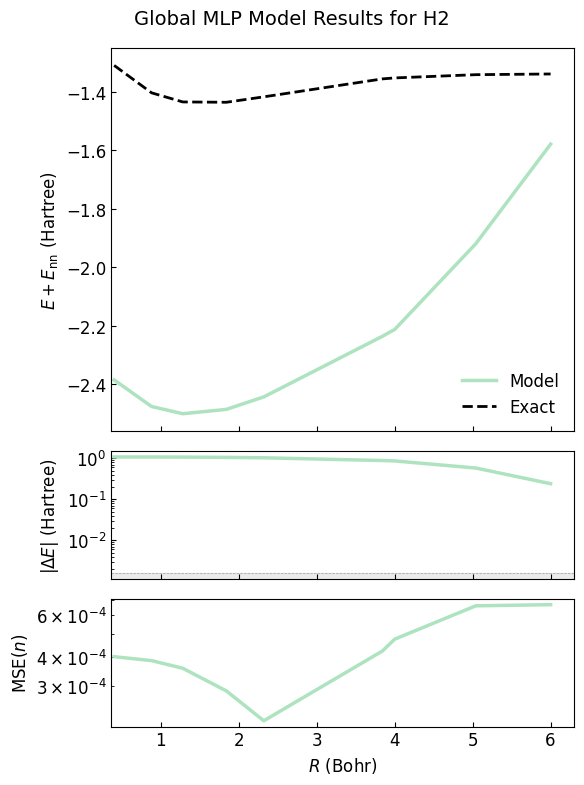

In [22]:
# Extract exact densities if available
try:
    exact_densities = plot_set.density
except AttributeError:
    exact_densities = None

# Create the plot
fig, axs = plot_results(
    plot_distances=plot_distances,
    nuclear_energy=nuclear_energy,
    states=states_global_mlp,
    plot_set=plot_set,
    title=f"Global MLP Model Results for H2",
    save_path="global_mlp_model_results.png",
    show_legend=True,
    color_idx=0
)

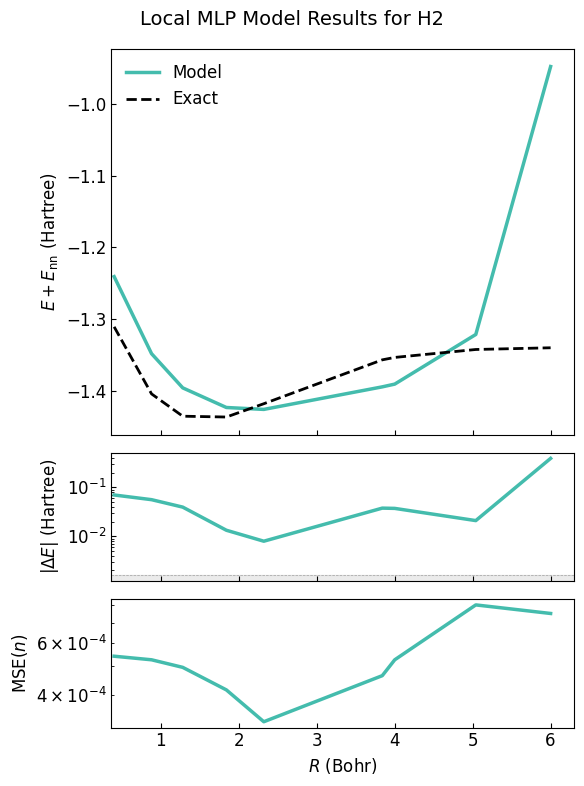

In [23]:
# Extract exact densities if available
try:
    exact_densities = plot_set.density
except AttributeError:
    exact_densities = None

# Create the plot
fig, axs = plot_results(
    plot_distances=plot_distances,
    nuclear_energy=nuclear_energy,
    states=states_local_mlp,
    plot_set=plot_set,
    title=f"Local MLP Model Results for H2",
    save_path="local_mlp_model_results.png",
    show_legend=True,
    color_idx=2
)

# Summary

This notebook demonstrates training a quantum-enhanced DFT model:

1. Configuration setup with parameters for model architecture, training, etc.
2. Loading molecular dataset for H2 molecule with grid size 513
3. Initializing neural network for exchange-correlation energy density
4. Testing direct initialization networks with random inputs
5. Creating and training Kohn-Sham model:
   - Setting up Kohn-Sham function and batching
   - Initializing loss function
   - Creating training step with gradient computation
   - Optimizing using L-BFGS-B algorithm
6. Training with Local MLP model
7. Training with Global MLP model
   - The model uses global encoding and trains on H2 molecular data to learn
the exchange-correlation functional.

